In [1]:
# Import libraries

import pandas as pd       
import matplotlib as mat
import matplotlib.pyplot as plt    
import numpy as np
import seaborn as sns
%matplotlib inline

pd.options.display.max_colwidth = 100

import random
import os

os.environ['TF_DETERMINISTIC_OPS'] = '1'

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob
import cv2

import warnings
warnings.filterwarnings('ignore')

In [2]:
IMG_SIZE = 150
BATCH = 32

In [3]:
main_path = r"C:\Users\vladp\OneDrive\Desktop\Y3\DataScience\assignment2\Datascience2025_A2\data\chest_xray\chest_xray"


train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

In [ ]:
# Convert data into dataframes 

train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

In [5]:
train_df, val_df = train_test_split(df_train, test_size = 0.20, stratify = df_train['class'])

In [6]:
# Load data

train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  #rotation_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH)
                                            
ds_test = val_datagen.flow_from_dataframe(df_test,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

Found 4172 validated image filenames belonging to 2 classes.
Found 1044 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [7]:
#Setting call backs

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 1e-7,                                
    cooldown = 0,                               
    verbose = 1
) 

In [ ]:
#  Remove the ‘head’, responsible for assigning the classes in this other dataset, and keep all the previous layers. 
#  Include last few layers, including the one responsible for generating the output.

base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)

base_model.trainable = False

def get_pretrained():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    x = base_model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [9]:
# Compile model

keras.backend.clear_session()

model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=5e-5), metrics=['binary_accuracy'])


In [10]:
# Training the model

history = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 12,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=int((len(train_df)/BATCH)),
          validation_steps=int((len(val_df)/BATCH)));

Epoch 1/12
130/130 ━━━━━━━━━━━━━━━━━━━━ 451s 3s/step - binary_accuracy: 0.8368 - loss: 0.3690 - val_binary_accuracy: 0.9121 - val_loss: 0.2047 - learning_rate: 5.0000e-05
Epoch 2/12
130/130 ━━━━━━━━━━━━━━━━━━━━ 86s 645ms/step - binary_accuracy: 0.9688 - loss: 0.1305 - val_binary_accuracy: 0.9121 - val_loss: 0.2048 - learning_rate: 5.0000e-05
Epoch 3/12
130/130 ━━━━━━━━━━━━━━━━━━━━ 430s 3s/step - binary_accuracy: 0.9004 - loss: 0.2291 - val_binary_accuracy: 0.9248 - val_loss: 0.1777 - learning_rate: 5.0000e-05
Epoch 4/12
130/130 ━━━━━━━━━━━━━━━━━━━━ 85s 640ms/step - binary_accuracy: 0.9375 - loss: 0.1294 - val_binary_accuracy: 0.9268 - val_loss: 0.1747 - learning_rate: 5.0000e-05
Epoch 5/12
130/130 ━━━━━━━━━━━━━━━━━━━━ 432s 3s/step - binary_accuracy: 0.9434 - loss: 0.1647 - val_binary_accuracy: 0.9355 - val_loss: 0.1607 - learning_rate: 5.0000e-05
Epoch 6/12
130/130 ━━━━━━━━━━━━━━━━━━━━ 84s 630ms/step - binary_accuracy: 0.9375 - loss: 0.1540 - val_binary_accuracy: 0.9404 - val_loss: 0.1

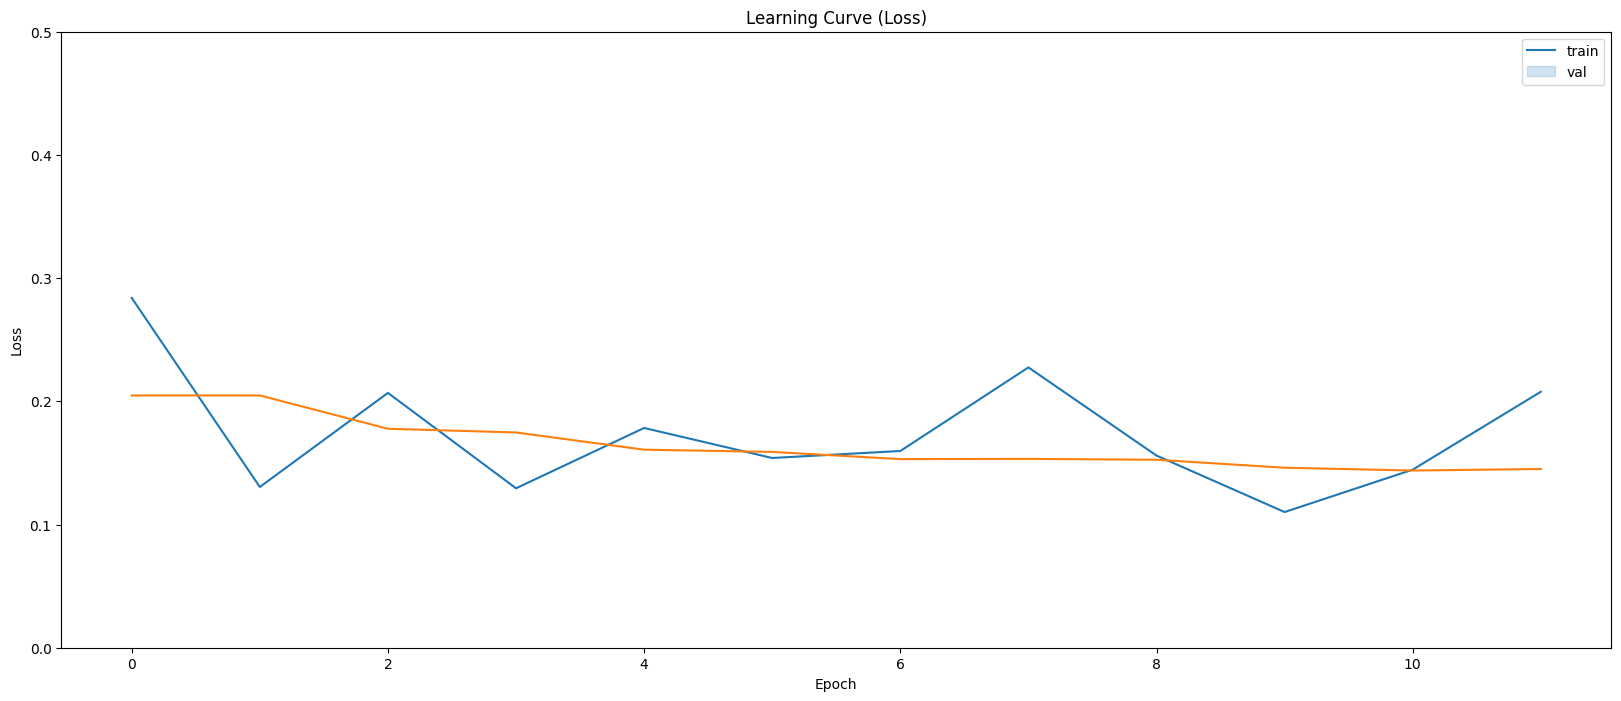

In [11]:
# Calculate and plot learning curve for loss

fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

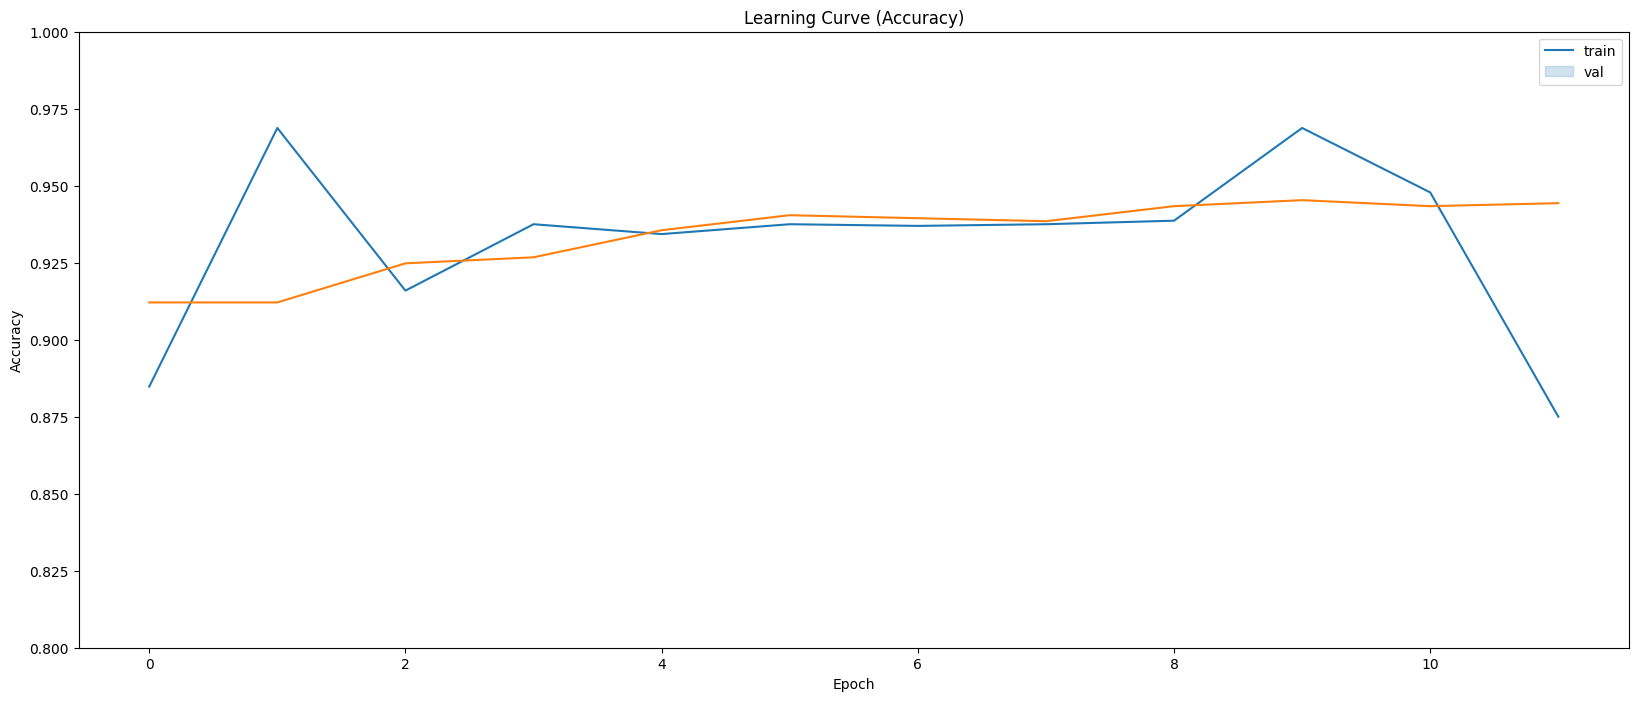

In [12]:
# Calculate and plot learning curve for accuracy

fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.80, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [13]:
# Set up labels and obtain results for matrices

num_label = {'Normal': 0, 'Pneumonia' : 1}
Y_test = df_test['class'].copy().map(num_label).astype('int')

ds_test.reset()
predictions = model_pretrained.predict(ds_test, steps=len(ds_test), verbose=0)
pred_labels= np.where(predictions>0.5, 1, 0)

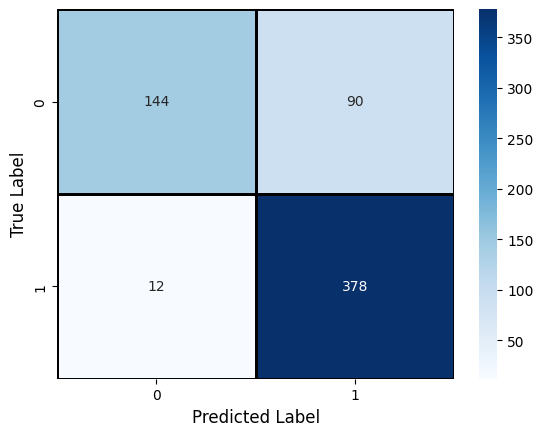

In [14]:
# Create confusion matrix

confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, cmap="Blues", linecolor='black', linewidth=1,
         annot=True, fmt='d')

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [15]:
# Create metrics classification report

print(metrics.classification_report(Y_test, pred_labels, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.92      0.62      0.74       234
           1       0.81      0.97      0.88       390

    accuracy                           0.84       624
   macro avg       0.87      0.79      0.81       624
weighted avg       0.85      0.84      0.83       624

